In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [50]:
from scipy import stats
import statsmodels.api as sm
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy

In [51]:
roary = '../../out/gene_presence_absence_roary.csv'
ref = '../../out/C001-001-P2.emapper.annotations'

In [52]:
wg = "../../out/associations/annotated_summary_wg_cov.tsv"
wg_ann = "../../out/associations/summary.emapper.annotations"
peu = "../../out/peu/annotated_summary_wg_cov.tsv"
peu_ann = "../../out/peu/summary.emapper.annotations"
ped = "../../out/ped/annotated_summary_wg_cov.tsv"
ped_ann = "../../out/ped/summary.emapper.annotations"
b2 = "../../out/b2/annotated_summary_cov.tsv"
b2_ann = "../../out/b2/summary.emapper.annotations"

In [53]:
ogs_all = set(pd.read_csv(wg, sep='\t', index_col=0).index)
ogs_peu = set(pd.read_csv(peu, sep='\t', index_col=0).index)
ogs_ped = set(pd.read_csv(ped, sep='\t', index_col=0).index)
ogs_b2 = set(pd.read_csv(b2, sep='\t', index_col=0).index)

In [54]:
cogs = 'ABCDEFGHIJKLMNOPQRSTUYZ'

In [55]:
pan = pd.read_csv(roary, sep=',', index_col=0, low_memory=False)['C001-001-P2']

In [56]:
pan

Gene
slyX           C001-001-P2_01760
group_19070    C001-001-P2_01753
rpsR           C001-001-P2_03842
rpmB           C001-001-P2_02940
group_18772    C001-001-P2_02824
                     ...        
group_29                     NaN
group_19                     NaN
group_2                      NaN
group_1                      NaN
group_0                      NaN
Name: C001-001-P2, Length: 31322, dtype: object


# **COG**

CELLULAR PROCESSES AND SIGNALING

    D Cell cycle control, cell division, chromosome partitioning
    M Cell wall/membrane/envelope biogenesis
    N Cell motility
    O Post-translational modification, protein turnover, and chaperones
    T Signal transduction mechanisms
    U Intracellular trafficking, secretion, and vesicular transport
    V Defense mechanisms
    W Extracellular structures
    Y Nuclear structure
    Z Cytoskeleton

INFORMATION STORAGE AND PROCESSING

    A RNA processing and modification
    B Chromatin structure and dynamics
    J Translation, ribosomal structure and biogenesis
    K Transcription
    L Replication, recombination and repair

METABOLISM

    C Energy production and conversion
    E Amino acid transport and metabolism
    F Nucleotide transport and metabolism
    G Carbohydrate transport and metabolism
    H Coenzyme transport and metabolism
    I Lipid transport and metabolism
    P Inorganic ion transport and metabolism
    Q Secondary metabolites biosynthesis, transport, and catabolism

POORLY CHARACTERIZED

    R General function prediction only
    S Function unknown



In [57]:
categs = {'D': 'Cell cycle control, cell division, chromosome partitioning',
'M': 'Cell wall/membrane/envelope biogenesis',
'N': 'Cell motility',
'O': 'Post-translational modification, protein turnover, and chaperones',
'T': 'Signal transduction mechanisms',
'U': 'Intracellular trafficking, secretion, and vesicular transport',
'V': 'Defense mechanisms',
'W': 'Extracellular structures',
'Y': 'Nuclear structure',
'Z': 'Cytoskeleton',
'A': 'RNA processing and modification',
'B': 'Chromatin structure and dynamics',
'J': 'Translation, ribosomal structure and biogenesis',
'K': 'Transcription',
'L': 'Replication, recombination and repair',
'C': 'Energy production and conversion',
'E': 'Amino acid transport and metabolism',
'F': 'Nucleotide transport and metabolism',
'G': 'Carbohydrate transport and metabolism',
'H': 'Coenzyme transport and metabolism',
'I': 'Lipid transport and metabolism',
'P': 'Inorganic ion transport and metabolism',
'Q': 'Secondary metabolites biosynthesis, transport, and catabolism',
'R': 'General function prediction only',
'S': 'Function unknown',
'X': 'Not annotated'}

In [58]:
# load reference COG category -> will be the same one used for all the analysis
# the reference was randomly selected, just taking into account that it was a B2 strain ST 131
# the reference is used to have a background for the COG erinchment analyis and GO terms

In [59]:
m = pd.read_csv(ref, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
m.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
m = m.drop(m.tail(3).index)
m.loc[m.index.difference(m['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [60]:
m

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
0,dkgB~~~~~~dkgB_1~~~dkgB_2,481805.EcolC_3458,1.050000e-183,511.0,"COG0656@1|root,COG0656@2|Bacteria,1MWFS@1224|P...",2|Bacteria,S,"Catalyzes the reduction of 2,5-diketo-D-glucon...",dkgB,"GO:0003674,GO:0003824,GO:0004033,GO:0005575,GO...",...,ko:K06222,-,-,-,-,"ko00000,ko01000",-,-,iEcolC_1368.EcolC_3458,Aldo_ket_red
1,dmlR_4~~~dmlR_3~~~~~~dmlR_5,469008.B21_00206,2.240000e-208,577.0,"COG0583@1|root,COG0583@2|Bacteria,1MU7H@1224|P...",2|Bacteria,K,Transcriptional regulator,yafC,"GO:0003674,GO:0003676,GO:0003677,GO:0003700,GO...",...,-,-,-,-,-,-,-,-,-,"HTH_1,LysR_substrate"
2,group_4214,199310.c0246,1.100000e-193,537.0,"COG3021@1|root,COG3021@2|Bacteria,1MVPP@1224|P...",2|Bacteria,S,UPF0294 protein YafD,yafD,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,-,-,-,-,-,-,-,-,-,Exo_endo_phos
3,ycgJ,362663.ECP_0216,1.550000e-175,490.0,"COG0500@1|root,COG2226@2|Bacteria,1PN45@1224|P...",2|Bacteria,Q,S-adenosylmethionine-dependent methyltransfera...,yafE,"GO:0003674,GO:0003824,GO:0005575,GO:0005622,GO...",...,-,-,-,-,-,-,-,-,-,Methyltransf_11
4,mltD_2~~~mltD_1~~~mltD,199310.c0248,4.910000e-293,801.0,"COG0741@1|root,COG1388@1|root,COG0741@2|Bacter...",2|Bacteria,M,Murein-degrading enzyme. May play a role in re...,mltD,"GO:0000270,GO:0003674,GO:0003824,GO:0005575,GO...",...,"ko:K08307,ko:K12204",-,-,-,-,"ko00000,ko01000,ko01011,ko02044","3.A.7.10.1,3.A.7.9.1",-,-,"LysM,SLT"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,group_11249,198214.SF2997,1.290000e-12,61.6,"2CZYD@1|root,32T7D@2|Bacteria,1N2MQ@1224|Prote...",2|Bacteria,S,Protein of unknown function (DUF987),ykfH,-,...,-,-,-,-,-,-,-,-,-,DUF987
4590,group_13208,1120963.KB894492_gene1480,3.700000e-11,64.3,"COG0697@1|root,COG0697@2|Bacteria,1N1QZ@1224|P...",2|Bacteria,EG,EamA-like transporter family,ydzE,"GO:0005575,GO:0005623,GO:0005886,GO:0016020,GO...",...,-,-,-,-,-,-,-,-,-,EamA
4591,group_13698,199310.c3664,0.000000e+00,1007.0,"COG2020@1|root,COG2020@2|Bacteria,1R7V9@1224|P...",2|Bacteria,O,methyltransferase activity,yeeR,"GO:0005575,GO:0005623,GO:0005886,GO:0016020,GO...",...,-,-,-,-,-,-,-,-,-,-
4592,group_15154,214092.5832425,4.080000e-117,339.0,"COG1484@1|root,COG1484@2|Bacteria,1MWQX@1224|P...",2|Bacteria,L,"ATP-binding protein, IstB SW ISTB_ECOLI (P1502...",-,-,...,-,-,-,-,-,-,-,-,-,IstB_IS21


In [61]:
### wg newly associated with covariates: sex, date collection, age ####
q = pd.read_csv(wg_ann, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
q.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
q = q.drop(q.tail(3).index)
q.loc[q.index.difference(q['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [62]:
q.shape

(26, 21)

In [63]:
res = []
for cog in cogs + 'X':
    pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
    pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]

    study_c = q[q['COG_category'].str.contains(cog)].shape[0]
    study_n = q[~q['COG_category'].str.contains(cog)].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
        pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]
        
        r = m.sample(q.shape[0])
        study_r_c = r[r['COG_category'].str.contains(cog)].shape[0]
        study_r_n = r[~r['COG_category'].str.contains(cog)].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((cog, categs[cog], pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['cog', 'category', 'pvalue', 'empirical-qvalue'])

In [64]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['cog', 'category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [65]:
qq = r.copy()

In [66]:
qq[qq['empirical-qvalue'] < 0.05]

,cog,category,pvalue,qvalue,empirical-qvalue
10,K,Transcription,0.005408,0.064891,0.001194
11,L,"Replication, recombination and repair",0.001727,0.041450,0.000005


In [67]:
qq['log pvalue'] = np.log10(qq['empirical-qvalue'])
qq['-log pvalue'] = -qq['log pvalue']

No handles with labels found to put in legend.


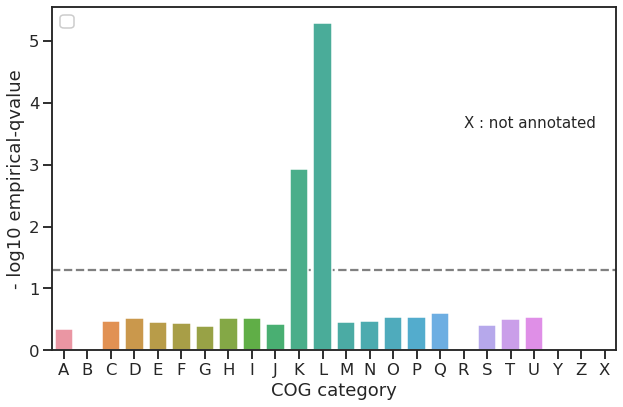

In [68]:
#fig, ax = plt.subplots()
cp = sns.catplot(data=qq,
                 x='cog', y='-log pvalue',
                 legend=False,
                 kind='bar',
                 dodge=True,
                 height=6,
                 aspect=1.5)

plt.xlabel("COG category")
plt.ylabel("- log10 empirical-qvalue")
sns.despine(top=False,
            right=False)
plt.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)
legend = plt.legend(loc='upper left')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

plt.text(17, 3.8, "X : not annotated", size=15,
         ha="left", va="top")
         
plt.savefig('../../out/figures/cogs_output.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/cogs_output.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

### PEU

In [69]:
### peu with new covariates ##
u = pd.read_csv(peu_ann, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
u.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
u = u.drop(u.tail(3).index)
u.loc[u.index.difference(u['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [70]:
res = []
for cog in cogs + 'X':
    pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
    pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]

    study_c = u[u['COG_category'].str.contains(cog)].shape[0]
    study_n = u[~u['COG_category'].str.contains(cog)].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
        pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]
        
        r = m.sample(u.shape[0])
        study_r_c = r[r['COG_category'].str.contains(cog)].shape[0]
        study_r_n = r[~r['COG_category'].str.contains(cog)].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((cog, categs[cog], pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['cog', 'category', 'pvalue', 'empirical-qvalue'])

In [71]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['cog', 'category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [72]:
vv = r.copy()

In [73]:
vv[vv['empirical-qvalue'] < 0.05]

,cog,category,pvalue,qvalue,empirical-qvalue
11,L,"Replication, recombination and repair",0.00006,0.001441,0.000053


In [74]:
vv['log pvalue'] = np.log10(vv['empirical-qvalue'])
vv['-log pvalue'] = -vv['log pvalue']

### **PED**

In [75]:
d = pd.read_csv(ped_ann, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
d.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
d = d.drop(d.tail(3).index)
d.loc[d.index.difference(d['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [76]:
d = d[d['query'].isin(ogs_ped)]

In [77]:
res = []
for cog in cogs + 'X':
    pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
    pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]

    study_c = d[d['COG_category'].str.contains(cog)].shape[0]
    study_n = d[~d['COG_category'].str.contains(cog)].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
        pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]
        
        r = m.sample(d.shape[0])
        study_r_c = r[r['COG_category'].str.contains(cog)].shape[0]
        study_r_n = r[~r['COG_category'].str.contains(cog)].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((cog, categs[cog], pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['cog', 'category', 'pvalue', 'empirical-qvalue'])

In [78]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['cog', 'category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [79]:
pp = r.copy()

In [80]:
pp[pp['empirical-qvalue'] < 0.05]

,cog,category,pvalue,qvalue,empirical-qvalue
11,L,"Replication, recombination and repair",0.013777,0.330636,0.04434


In [81]:
r.to_csv('../../out/ped/cog.tsv', sep='\t', index=False)

### **B2**

In [82]:
n = pd.read_csv(b2_ann, sep='\t', skiprows=[0, 1, 2, 3, 4], header=None)
n.columns = ['query', 'seed_ortholog', 'evalue',
             'score', 'eggNOG_OGs', 'max_annot_lvl',
             'COG_category', 'Description', 'Preferred_name', 
             'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
             'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs']
n = n.drop(n.tail(3).index)
n.loc[n.index.difference(n['COG_category'].dropna().index),
      'COG_category'] = 'X'

In [83]:
n = n[n['query'].isin(ogs_b2)]

In [84]:
res = []
for cog in cogs + 'X':
    pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
    pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]

    study_c = n[n['COG_category'].str.contains(cog)].shape[0]
    study_n = n[~n['COG_category'].str.contains(cog)].shape[0]

    table = [[study_c, pop_c],
             [study_n, pop_n]]
    odds_ratio, pvalue = stats.fisher_exact(table, alternative='greater')
        
    # empirical
    ratios = []
    for _ in range(100):
        pop_c = m[m['COG_category'].str.contains(cog)].shape[0]
        pop_n = m[~m['COG_category'].str.contains(cog)].shape[0]
        
        r = m.sample(n.shape[0])
        study_r_c = r[r['COG_category'].str.contains(cog)].shape[0]
        study_r_n = r[~r['COG_category'].str.contains(cog)].shape[0]
        
        table = [[study_r_c, pop_c],
                 [study_r_n, pop_n]]
        ratios.append(stats.fisher_exact(table, alternative='greater')[0])

    zscores = stats.zscore(ratios + [odds_ratio])
    pvalues = stats.norm.sf(abs(zscores))
    qvalues = sm.stats.multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    
    res.append((cog, categs[cog], pvalue, qvalues[-1]))

r = pd.DataFrame(res,
                 columns=['cog', 'category', 'pvalue', 'empirical-qvalue'])

In [85]:
r['qvalue'] = sm.stats.multipletests(r['pvalue'], alpha=0.05, method='fdr_bh')[1]
r = r[['cog', 'category', 'pvalue', 'qvalue', 'empirical-qvalue']]

In [86]:
bb = r.copy()

In [87]:
bb[bb['empirical-qvalue'] < 0.05]

,cog,category,pvalue,qvalue,empirical-qvalue
11,L,"Replication, recombination and repair",0.012179,0.275113,0.006645
16,Q,"Secondary metabolites biosynthesis, transport,...",0.022926,0.275113,0.017875


In [88]:
r.to_csv('../../out/b2/cog.tsv', sep='\t', index=False)

-----------------------

PLOT

In [89]:
qq['type'] = ['Full dataset' if x != 0
               else 0
               for x in qq['pvalue']]
vv['type'] = ['PE: Urinary tract' if x != 0
               else 0
               for x in vv['pvalue']]
pp['type'] = ['PE: Digestive tract' if x != 0
               else 0
               for x in pp['pvalue']]
bb['type'] = ['B2 strains' if x != 0
               else 0
               for x in bb['pvalue']]

In [90]:
ff = pd.concat([qq, vv, pp])

In [91]:
ff['log pvalue'] = np.log10(ff['empirical-qvalue'])
ff['-log pvalue'] = -ff['log pvalue']

In [92]:
ff[ff['empirical-qvalue'] < 0.05]

,cog,category,pvalue,qvalue,empirical-qvalue,log pvalue,-log pvalue,type
10,K,Transcription,0.005408,0.064891,0.001194,-2.923024,2.923024,Full dataset
11,L,"Replication, recombination and repair",0.001727,0.041450,0.000005,-5.288027,5.288027,Full dataset
11,L,"Replication, recombination and repair",0.000060,0.001441,0.000053,-4.279322,4.279322,PE: Urinary tract
11,L,"Replication, recombination and repair",0.013777,0.330636,0.044340,-1.353208,1.353208,PE: Digestive tract


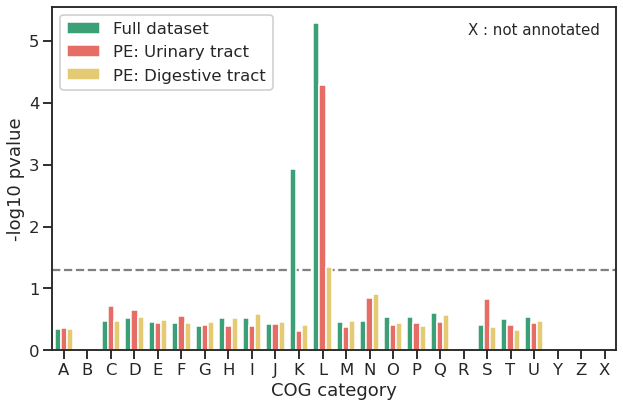

In [96]:
#fig, ax = plt.subplots()
cp = sns.catplot(data=ff,
                 x='cog', y='-log pvalue',
                 hue = 'type',
                 legend=False,
                 kind='bar',
                 dodge=True,
                 height=6,
                 aspect=1.5,
                 palette=['xkcd:bluey green', 'xkcd:coral', 'xkcd:light mustard', 'xkcd:turquoise blue'])

plt.xlabel("COG category")
plt.ylabel("-log10 pvalue")
sns.despine(top=False,
            right=False)
plt.axhline(-np.log10(0.05), color='grey', ls='dashed', zorder=0)
legend = plt.legend(loc='upper left')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

plt.text(17.2, 5.3, "X : not annotated", size=15,
         ha="left", va="top")
         
plt.savefig('../../out/figures/cogs_output.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('../../out/figures/cogs_output.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

# GO terms

In [25]:
!wget --quiet -O go-basic.obo "http://purl.obolibrary.org/obo/go/go-basic.obo"

In [52]:
obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2022-10-07) 46,824 Terms


In [53]:
og = {}
for k, v in pan.dropna().iteritems():
    for g in v.split('\t'):
        og[g] = k

### **WG**

In [56]:
#### GO terms enrichment ####
assoc = {og.get(k, k): {y for y in v.split(',')}
         for k, v in m.set_index('query')['GOs'].dropna().to_dict().items()}
for k, v in q.set_index('query')['GOs'].dropna().to_dict().items():
    if k in assoc:
        continue
    assoc[k] = {y for y in v.split(',')}

In [57]:
go = GOEnrichmentStudy(assoc.keys(), assoc, obodag, methods=['fdr_bh'])
res = go.run_study(set(q['query']))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,610 of  4,610 population items found in association

Runing  Ontology Analysis: current study set of 26 IDs.
100%     26 of     26 study items found in association
100%     26 of     26 study items found in population(4610)
Calculating 5,945 uncorrected p-values using fisher_scipy_stats


132 GO IDs NOT FOUND IN ASSOCIATION: GO:0052143 GO:0044432 GO:0034419 GO:0051193 GO:0009109 GO:0044425 GO:0044422 GO:0031233 GO:0031235 GO:0000746 GO:0000726 GO:0018307 GO:0051184 GO:0051271 GO:0006733 GO:0004158 GO:0008144 GO:0000988 GO:0051196 GO:0044437 GO:0071575 GO:0044421 GO:0051272 GO:0042891 GO:0018065 GO:0039633 GO:0009108 GO:0070035 GO:0051188 GO:0008905 GO:0000990 GO:0072321 GO:0052192 GO:0016676 GO:0044427 GO:0052212 GO:0042954 GO:0000989 GO:0043901 GO:0052195 GO:0031224 GO:0047138 GO:0055114 GO:0031226 GO:0044433 GO:0044452 GO:0052243 GO:0102132 GO:0015491 GO:0044428 GO:0031237 GO:0044445 GO:0044456 GO:0031225 GO:0051801 GO:0102131 GO:0120038 GO:0097223 GO:0051883 GO:0016458 GO:0048037 GO:0052047 GO:0051187 GO:0022610 GO:0001302 GO:0044459 GO:0044436 GO:0051186 GO:0015301 GO:0031362 GO:0051181 GO:0036405 GO:1990507 GO:0046218 GO:0009405 GO:0044464 GO:0043900 GO:0000229 GO:0044444 GO:0044110 GO:0051182 GO:0015922 GO:0001871 GO:0045203 GO:0046144 GO:0044454 GO:0046145 GO:005

   5,945 terms are associated with  3,513 of  4,610 population items
     245 terms are associated with      7 of     26 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  0 enriched +   5 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       7 study items associated with significant GO IDs (purified)


In [58]:
passing = [x for x in res
           if x.get_pvalue() < 0.05]

In [59]:
passing

[GOEnrichmentRecord(GO:0008150),
 GOEnrichmentRecord(GO:0009987),
 GOEnrichmentRecord(GO:0110165),
 GOEnrichmentRecord(GO:0005575),
 GOEnrichmentRecord(GO:0003674)]

In [60]:
res = []
for go in passing:
    go.study_items = ['%s' % x for x in go.study_items]
    res.append(str(go).split('\t'))
r = pd.DataFrame(res,
                 columns=go.get_prtflds_default())

In [61]:
r

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0008150,BP,p,biological_process,6/26,3152/4610,2.53e-06,0,6,0.015,"fliI~~~fliI_2~~~atpB_2~~~fliI_1, group_17552, ..."
1,GO:0009987,BP,p,cellular process,5/26,2815/4610,1.8e-05,1,5,0.0356,"fliI~~~fliI_2~~~atpB_2~~~fliI_1, group_17552, ..."
2,GO:0110165,CC,p,cellular anatomical entity,4/26,2739/4610,6.07e-06,1,4,0.0181,"fliI~~~fliI_2~~~atpB_2~~~fliI_1, group_8552, g..."
3,GO:0005575,CC,p,cellular_component,5/26,2770/4610,2.58e-05,0,5,0.0383,"fliI~~~fliI_2~~~atpB_2~~~fliI_1, group_17552, ..."
4,GO:0003674,MF,p,molecular_function,6/26,2943/4610,3.39e-05,0,6,0.0403,"fliI~~~fliI_2~~~atpB_2~~~fliI_1, group_17552, ..."


In [62]:
r.to_csv('../../out/associations/go_terms.csv', sep='\t', index=False)

### **PEU**

In [70]:
assoc = {og.get(k, k): {y for y in v.split(',')}
         for k, v in m.set_index('query')['GOs'].dropna().to_dict().items()}
for k, v in u.set_index('query')['GOs'].dropna().to_dict().items():
    if k in assoc:
        continue
    assoc[k] = {y for y in v.split(',')}

In [71]:
go = GOEnrichmentStudy(assoc.keys(), assoc, obodag, methods=['fdr_bh'])
res = go.run_study(set(u['query']))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,643 of  4,643 population items found in association

Runing  Ontology Analysis: current study set of 80 IDs.
100%     80 of     80 study items found in association
100%     80 of     80 study items found in population(4643)
Calculating 5,945 uncorrected p-values using fisher_scipy_stats


132 GO IDs NOT FOUND IN ASSOCIATION: GO:0052143 GO:0044432 GO:0034419 GO:0051193 GO:0009109 GO:0044425 GO:0044422 GO:0031233 GO:0031235 GO:0000746 GO:0000726 GO:0018307 GO:0051184 GO:0051271 GO:0006733 GO:0004158 GO:0008144 GO:0000988 GO:0051196 GO:0044437 GO:0071575 GO:0044421 GO:0051272 GO:0042891 GO:0018065 GO:0039633 GO:0009108 GO:0070035 GO:0051188 GO:0008905 GO:0000990 GO:0072321 GO:0052192 GO:0016676 GO:0044427 GO:0052212 GO:0042954 GO:0000989 GO:0043901 GO:0052195 GO:0031224 GO:0047138 GO:0055114 GO:0031226 GO:0044433 GO:0044452 GO:0052243 GO:0102132 GO:0015491 GO:0044428 GO:0031237 GO:0044445 GO:0044456 GO:0031225 GO:0051801 GO:0102131 GO:0120038 GO:0097223 GO:0051883 GO:0016458 GO:0048037 GO:0052047 GO:0051187 GO:0022610 GO:0001302 GO:0044459 GO:0044436 GO:0051186 GO:0015301 GO:0031362 GO:0051181 GO:0036405 GO:1990507 GO:0046218 GO:0009405 GO:0044464 GO:0043900 GO:0000229 GO:0044444 GO:0044110 GO:0051182 GO:0015922 GO:0001871 GO:0045203 GO:0046144 GO:0044454 GO:0046145 GO:005

   5,945 terms are associated with  3,516 of  4,643 population items
     465 terms are associated with     24 of     80 study items
  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) (  0 enriched +  19 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      24 study items associated with significant GO IDs (purified)


In [72]:
passing = [x for x in res
           if x.get_pvalue() < 0.05]

In [73]:
passing

[GOEnrichmentRecord(GO:0008150),
 GOEnrichmentRecord(GO:0009987),
 GOEnrichmentRecord(GO:0008152),
 GOEnrichmentRecord(GO:0044237),
 GOEnrichmentRecord(GO:0071704),
 GOEnrichmentRecord(GO:0044238),
 GOEnrichmentRecord(GO:0006807),
 GOEnrichmentRecord(GO:0110165),
 GOEnrichmentRecord(GO:0005575),
 GOEnrichmentRecord(GO:0005622),
 GOEnrichmentRecord(GO:0005737),
 GOEnrichmentRecord(GO:0005829),
 GOEnrichmentRecord(GO:0016020),
 GOEnrichmentRecord(GO:0071944),
 GOEnrichmentRecord(GO:0003674),
 GOEnrichmentRecord(GO:0003824),
 GOEnrichmentRecord(GO:0005488),
 GOEnrichmentRecord(GO:0043167),
 GOEnrichmentRecord(GO:0005215)]

In [74]:
res = []
for go in passing:
    go.study_items = ['%s' % x for x in go.study_items]
    res.append(str(go).split('\t'))
r = pd.DataFrame(res,
                 columns=go.get_prtflds_default())

In [75]:
r

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0008150,BP,p,biological_process,21/80,3155/4643,1.44e-14,0,21,2.15e-11,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, epsM_1~~~..."
1,GO:0009987,BP,p,cellular process,20/80,2818/4643,7.6e-11,1,20,9.03e-08,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, epsM_1~~~..."
2,GO:0008152,BP,p,metabolic process,15/80,2289/4643,1.36e-08,1,15,1.34e-05,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, galF~~~ga..."
3,GO:0044237,BP,p,cellular metabolic process,15/80,1988/4643,6.04e-06,2,15,0.00279,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, galF~~~ga..."
4,GO:0071704,BP,p,organic substance metabolic process,15/80,1986/4643,6.11e-06,2,15,0.00279,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, galF~~~ga..."
5,GO:0044238,BP,p,primary metabolic process,13/80,1757/4643,3.47e-05,2,13,0.0121,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, galF~~~ga..."
6,GO:0006807,BP,p,nitrogen compound metabolic process,11/80,1575/4643,6.42e-05,2,11,0.0212,"aceF, dgcE_2~~~dgcE_1~~~dgcE, dhfrI, galF~~~ga..."
7,GO:0110165,CC,p,cellular anatomical entity,12/80,2739/4643,3.47e-16,1,12,2.06e-12,"aceF, dgcE_2~~~dgcE_1~~~dgcE, epsM_1~~~epsM~~~..."
8,GO:0005575,CC,p,cellular_component,13/80,2769/4643,1.05e-15,0,13,3.12e-12,"aceF, dgcE_2~~~dgcE_1~~~dgcE, epsM_1~~~epsM~~~..."
9,GO:0005622,CC,p,intracellular anatomical structure,5/80,1483/4643,3.64e-08,2,5,3.09e-05,"aceF, dgcE_2~~~dgcE_1~~~dgcE, galF~~~galF_1, u..."


In [76]:
r.to_csv('../../out/peu/go_terms.tsv', sep='\t', index=False)

### **PED**

In [77]:
assoc = {og.get(k, k): {y for y in v.split(',')}
         for k, v in m.set_index('query')['GOs'].dropna().to_dict().items()}
for k, v in d.set_index('query')['GOs'].dropna().to_dict().items():
    if k in assoc:
        continue
    assoc[k] = {y for y in v.split(',')}

In [78]:
go = GOEnrichmentStudy(assoc.keys(), assoc, obodag, methods=['fdr_bh'])
res = go.run_study(set(d['query']))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,614 of  4,614 population items found in association

Runing  Ontology Analysis: current study set of 39 IDs.
100%     39 of     39 study items found in association
100%     39 of     39 study items found in population(4614)
Calculating 5,945 uncorrected p-values using fisher_scipy_stats


132 GO IDs NOT FOUND IN ASSOCIATION: GO:0052143 GO:0044432 GO:0034419 GO:0051193 GO:0009109 GO:0044425 GO:0044422 GO:0031233 GO:0031235 GO:0000746 GO:0000726 GO:0018307 GO:0051184 GO:0051271 GO:0006733 GO:0004158 GO:0008144 GO:0000988 GO:0051196 GO:0044437 GO:0071575 GO:0044421 GO:0051272 GO:0042891 GO:0018065 GO:0039633 GO:0009108 GO:0070035 GO:0051188 GO:0008905 GO:0000990 GO:0072321 GO:0052192 GO:0016676 GO:0044427 GO:0052212 GO:0042954 GO:0000989 GO:0043901 GO:0052195 GO:0031224 GO:0047138 GO:0055114 GO:0031226 GO:0044433 GO:0044452 GO:0052243 GO:0102132 GO:0015491 GO:0044428 GO:0031237 GO:0044445 GO:0044456 GO:0031225 GO:0051801 GO:0102131 GO:0120038 GO:0097223 GO:0051883 GO:0016458 GO:0048037 GO:0052047 GO:0051187 GO:0022610 GO:0001302 GO:0044459 GO:0044436 GO:0051186 GO:0015301 GO:0031362 GO:0051181 GO:0036405 GO:1990507 GO:0046218 GO:0009405 GO:0044464 GO:0043900 GO:0000229 GO:0044444 GO:0044110 GO:0051182 GO:0015922 GO:0001871 GO:0045203 GO:0046144 GO:0044454 GO:0046145 GO:005

   5,945 terms are associated with  3,513 of  4,614 population items
     381 terms are associated with     16 of     39 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [79]:
passing = [x for x in res
           if x.get_pvalue() < 0.05]

In [80]:
passing

[]

### **B2**

In [81]:
assoc = {og.get(k, k): {y for y in v.split(',')}
         for k, v in m.set_index('query')['GOs'].dropna().to_dict().items()}
for k, v in n.set_index('query')['GOs'].dropna().to_dict().items():
    if k in assoc:
        continue
    assoc[k] = {y for y in v.split(',')}

In [82]:
go = GOEnrichmentStudy(assoc.keys(), assoc, obodag, methods=['fdr_bh'])
res = go.run_study(set(n['query']))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
100%  4,614 of  4,614 population items found in association

Runing  Ontology Analysis: current study set of 38 IDs.
100%     38 of     38 study items found in association
100%     38 of     38 study items found in population(4614)
Calculating 5,945 uncorrected p-values using fisher_scipy_stats


132 GO IDs NOT FOUND IN ASSOCIATION: GO:0052143 GO:0044432 GO:0034419 GO:0051193 GO:0009109 GO:0044425 GO:0044422 GO:0031233 GO:0031235 GO:0000746 GO:0000726 GO:0018307 GO:0051184 GO:0051271 GO:0006733 GO:0004158 GO:0008144 GO:0000988 GO:0051196 GO:0044437 GO:0071575 GO:0044421 GO:0051272 GO:0042891 GO:0018065 GO:0039633 GO:0009108 GO:0070035 GO:0051188 GO:0008905 GO:0000990 GO:0072321 GO:0052192 GO:0016676 GO:0044427 GO:0052212 GO:0042954 GO:0000989 GO:0043901 GO:0052195 GO:0031224 GO:0047138 GO:0055114 GO:0031226 GO:0044433 GO:0044452 GO:0052243 GO:0102132 GO:0015491 GO:0044428 GO:0031237 GO:0044445 GO:0044456 GO:0031225 GO:0051801 GO:0102131 GO:0120038 GO:0097223 GO:0051883 GO:0016458 GO:0048037 GO:0052047 GO:0051187 GO:0022610 GO:0001302 GO:0044459 GO:0044436 GO:0051186 GO:0015301 GO:0031362 GO:0051181 GO:0036405 GO:1990507 GO:0046218 GO:0009405 GO:0044464 GO:0043900 GO:0000229 GO:0044444 GO:0044110 GO:0051182 GO:0015922 GO:0001871 GO:0045203 GO:0046144 GO:0044454 GO:0046145 GO:005

   5,945 terms are associated with  3,513 of  4,614 population items
     436 terms are associated with     15 of     38 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [83]:
passing = [x for x in res
           if x.get_pvalue() < 0.05]

In [84]:
passing

[]